<a href="https://colab.research.google.com/github/ritwiks9635/Image-Similarity-/blob/main/Image_Similarity_search_using_Metrics_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Image Similarity search using Metrics Learning**

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from collections import defaultdict
from sklearn.metrics import confusion_matrix

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
y_train = np.squeeze(y_train)
x_test = x_test.astype("float32") / 255.0
y_test = np.squeeze(y_test)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
y_test

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

In [4]:
height_width = 32


def show_samples(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage

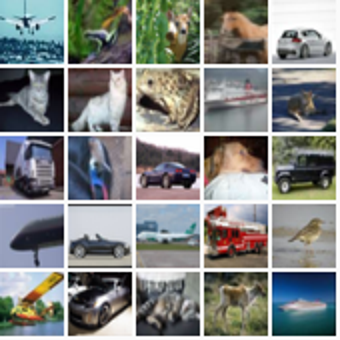

In [5]:
sample_idxs = np.random.randint(0, 50000, size=(5, 5))
examples = x_train[sample_idxs]
show_samples(examples)

In [6]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

In [7]:
num_classes = 10


class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batches):
        super().__init__()
        self._num_batches = num_batches

    def __len__(self):
        return self._num_batches

    def __getitem__(self, _idx):
        x = np.empty((2, num_classes, height_width, height_width, 3), dtype=np.float32)
        for class_idx in range(num_classes):
            examples_for_class = class_idx_to_train_idxs[class_idx]
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            while positive_idx == anchor_idx:
                positive_idx = random.choice(examples_for_class)
            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
        return x

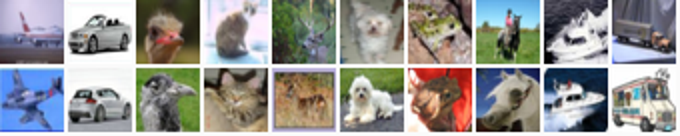

In [8]:
examples = next(iter(AnchorPositivePairs(1)))
show_samples(examples)

##**Embedding model**

We define a custom model with a train_step that first embeds both anchors and positives and then uses their pairwise dot products as logits for a softmax.

In [9]:
class EmbeddingModel(keras.Model):
    def train_step(self, data):
        # Note: Workaround for open issue, to be removed.
        if isinstance(data, tuple):
            data = data[0]
        anchors, positives = data[0], data[1]

        with tf.GradientTape() as tape:
            # Run both anchors and positives through model.
            anchor_embeddings = self(anchors, training=True)
            positive_embeddings = self(positives, training=True)

            # Calculate cosine similarity between anchors and positives. As they have
            # been normalised this is just the pair wise dot products.
            similarities = keras.ops.einsum(
                "ae,pe->ap", anchor_embeddings, positive_embeddings
            )

            # Since we intend to use these as logits we scale them by a temperature.
            # This value would normally be chosen as a hyper parameter.
            temperature = 0.2
            similarities /= temperature

            # We use these similarities as logits for a softmax. The labels for
            # this call are just the sequence [0, 1, 2, ..., num_classes] since we
            # want the main diagonal values, which correspond to the anchor/positive
            # pairs, to be high. This loss will move embeddings for the
            # anchor/positive pairs together and move all other pairs apart.
            sparse_labels = keras.ops.arange(num_classes)
            loss = self.compute_loss(y=sparse_labels, y_pred=similarities)

        # Calculate gradients and apply via optimizer.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update and return metrics (specifically the one for the loss value).
        for metric in self.metrics:
            # Calling `self.compile` will by default add a [`keras.metrics.Mean`](/api/metrics/metrics_wrappers#mean-class) loss
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(sparse_labels, similarities)

        return {m.name: m.result() for m in self.metrics}

In [10]:
inputs = keras.Input(shape = (height_width, height_width,  3))
x = layers.Conv2D(32, 3, strides = 2, activation = "relu")(inputs)
x = layers.Conv2D(64, 3, strides = 2, activation = "relu")(x)
x = layers.Conv2D(128, 3, strides = 2, activation = "relu")(x)
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(8, activation = None)(x)
embeddings = layers.UnitNormalization()(embeddings)
Model = EmbeddingModel(inputs, embeddings)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.2080
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.1079
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0349
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9984
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9781
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.9275
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9006
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.8562
Epoch 9/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8446
Epoch 10/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.8107
Epoch 11/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7832
Epoch 12/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.7599
Epoch 13/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7408
Epoch 14/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7377
Epoch 15/20
1000/1000 ━━━━━━

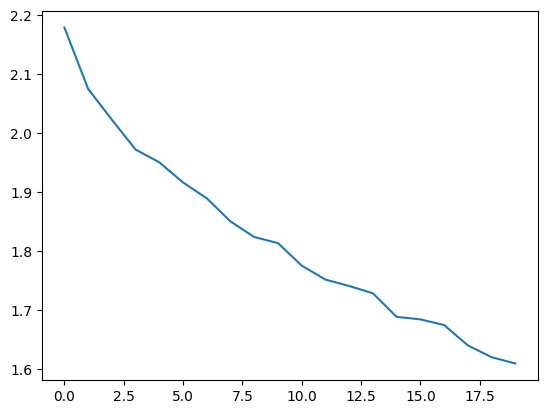

In [11]:
Model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 1e-3),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True))


history = Model.fit(AnchorPositivePairs(num_batches=1000), epochs=20)

plt.plot(history.history["loss"])
plt.show()

##**Testing**
We can review the quality of this model by applying it to the test set and considering near neighbours in the embedding space.

First we embed the test set and calculate all near neighbours. Recall that since the embeddings are unit length we can calculate cosine similarity via dot products.

In [13]:
near_neighbours_sample = 10
embeddings = Model.predict(x_test)
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
near_neighbour = np.argsort(gram_matrix.T)[:, -(near_neighbours_sample + 1) :]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


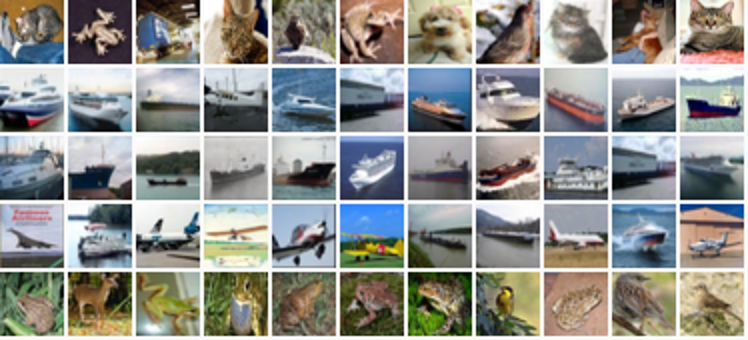

In [14]:
num_examples = 5

examples = np.empty(
    (
        num_examples,
        near_neighbours_sample + 1,
        height_width,
        height_width,
        3,
    ),
    dtype=np.float32,
)
for row_idx in range(num_examples):
    examples[row_idx, 0] = x_test[row_idx]
    anchor_near_neighbours = reversed(near_neighbour[row_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

show_samples(examples)